# Exam project: Scraping job postings from Jobindex

This notebook is used for webscraping www.jobindex.dk for all job postings in the period xxxx-2020. 

In [7]:
# Import necessary modules
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

#Make log
import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

#Define todays date
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101

### Define the maximum page number to do a FOR loop through
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination. The pagination looks as the picture below, and we want to save the number of the last page as "last_page" to be able to loop through it later on.  
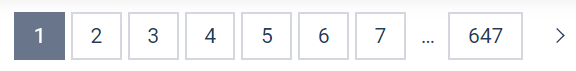

In [2]:
#Define the url and fetch the HTML using the requests module
url = 'https://www.jobindex.dk/jobsoegning?lang=da.html'
response = requests.get(url)  
html = response.text  
soup = BeautifulSoup(html,'lxml') # parse the raw html using BeautifoulSoup

#Find the pagination and extract the text-part of the pagination links, i.e. not the link but the page number. 
pagination = soup.find_all('a', {'class':'page-link'})
last_page = int(pagination[-1].text) #Save the last page number as "last page"
print(last_page)

650


### Extract all job postings from www.jobindex.dk. 
For each job posting one is redirected from www.jobindex.dk/jobsoegning to a separate www-webpage or PDF, that contains the full job posting. We therefore have to distinguish between these two.

In [535]:
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import pandas as pd

jobindex_links = []
for i in range(1,3): # NOTE I'm only testing it on the first two pages. Use last_page when ready
    url = f'https://www.jobindex.dk/jobsoegning?lang=da?page={i}.html'
    jobindex_links.append(url)   
#print(jobindex_links)
html = []
job_links = []
jobs = []
dates = []

for url in jobindex_links:
    response = requests.get(url)  
    html = response.text  
    soup = BeautifulSoup(html,'lxml')
    #one job result is given by class=jobsearch-result
    joblistings = soup.find_all('div',{'class':'jobsearch-result'})
    #print(joblistings)
    for joblisting in joblistings:
        title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
        links = re.findall("href=[\"\'](.*?)[\"\']", str(joblisting))
        link = str(links[1])
        link = link.replace("&amp;", "&")
        pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))
        dates.append(pub_date) 
        job = [title,link,pub_date]
        jobs.append(job) # Jobs is a list of list where each list contains the title job, and the link for that job, this will help later
        job_links.append(link)

for i in range(len(job_links)):
    if 'pdf' in jobs[i][1]:
        #scraping a PDF file
        #request the url
        url = jobs[i][1]
        response = requests.get(url)
        #save the pdf in the current folder
        with open('pdf.pdf', 'wb') as f:
            f.write(response.content)
        #open the pdf and get the text in doc
        with open('pdf.pdf', 'rb') as fp:
            doc = slate.PDF(fp)
            doc = str(doc).replace('\n','')
            doc = str(doc).replace('\r','')
            jobs[i].append(doc)
    else:
        link = jobs[i][1]
        response = requests.get(link)
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        description = soup.get_text()
        description = description.replace('\n','')
        description = description.replace('\r','')
        jobs[i].append(description)
    
    print('Completed %d/%d job_links' % (i,len(job_links)))

#transforming into dataframe

df = pd.DataFrame(jobs)
df.columns = ["Job Title", "Link","Date", "Description",]


Completed 0/40 of job_links
Completed 1/40 of job_links
Completed 2/40 of job_links
Completed 3/40 of job_links
Completed 4/40 of job_links
Completed 5/40 of job_links
Completed 6/40 of job_links
Completed 7/40 of job_links
Completed 8/40 of job_links
Completed 9/40 of job_links
Completed 10/40 of job_links
Completed 11/40 of job_links
Completed 12/40 of job_links
Completed 13/40 of job_links
Completed 14/40 of job_links
Completed 15/40 of job_links
Completed 16/40 of job_links
Completed 17/40 of job_links
Completed 18/40 of job_links
Completed 19/40 of job_links
Completed 20/40 of job_links
Completed 21/40 of job_links
Completed 22/40 of job_links
Completed 23/40 of job_links
Completed 24/40 of job_links
Completed 25/40 of job_links
Completed 26/40 of job_links
Completed 27/40 of job_links
Completed 28/40 of job_links
Completed 29/40 of job_links
Completed 30/40 of job_links
Completed 31/40 of job_links
Completed 32/40 of job_links
Completed 33/40 of job_links
Completed 34/40 of job_l

## Identifying jobs with possibility of working remotely

In [473]:
# First we define a list of keyword that we think a job posting where working remotely is a possibility will include

keywords = ['hjemmefra', 'arbejde hjemme', 'hjemmearbejde','hjemmekontor', 'arbejde hjemmefra', 'arbejde remote', 'fjernarbejde']

# I will now look for these words in the description column. I am not using the tokenized version of column because then I 
# can't look for expressions with more than one word. If you want to use the tokenized version then you have to use bigrams

df['Remote'] = '0'
for word in keywords:
    for i in range(len(df)):
        df['Description'][i] = str(df['Description'][i]).lower()
        if word in df['Description'][i]:
            df['Remote'][i] = '1'
            
        

## Identifying the most popular words in job descriptions

In [527]:
# The first step is to clean the job descriptions as much as possible so we can narrow down the words included for 
# analysis as much as possible

df['Tokenized_description'] = ' '
symbols = ['?','!','>','<','-','[',']','(',')','{','}',' –','``',"''",'""','\\','@','$','&','=']
for i in range(len(df)):
    stop_words = nltk.corpus.stopwords.words("danish")
    df['Tokenized_description'][i] = re.sub(r'(\.+ )|,|\||:|/|\'|\-|;|\*|!|(\s\d+\s)|(\s\W\s)',' ',str(df['Description'][i]))
    df['Tokenized_description'][i] = str(df['Tokenized_description'][i]).rstrip('\\')
    df['Tokenized_description'][i] = nltk.word_tokenize(str(df['Tokenized_description'][i].lower()))
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words] 
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in symbols]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w.isnumeric()]
    df['Tokenized_description'][i] = [word for word in df['Tokenized_description'][i] if len(word) > 3]
    
# Finding intersections --- USELESS
df['description_set'] = df['Tokenized_description'].apply(set)
description_set = df['description_set'].tolist() #convert each description into a set 
set.intersection(*description_set)
del df['description_set']

# Finding most frequent words in all descriptions --- USELESS ATM BUT MAYBE IF WE CLEAN IT ENOUGH IT WILL WORK

descriptions_list = [] 
# This loop will pull all tokens in one bag
for i in range(len(df)):
    descriptions_list.extend(df['Tokenized_description'][i]) 
    
word_dist = nltk.FreqDist(descriptions_list) word_dist

In [ ]:
# CELL DEDICATED TO KEEP CLEANING DESCRIPTIONS

def clean(doc):
    #doc = doc.replace('\n','')
    #doc = doc.replace('\r','')
    doc = doc.replace('\t','')
    doc = doc.replace('\'','')
    doc = doc.replace('|','')
    doc = doc.replace('/','')

def strip_html(row):
    return str(html.fromstring(row).text_content())

from lxml import html
for row in df['Description']:
    strip_html(str(row))
    
    
    
#text = re.sub('<[^>]*>', '', text)
#emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

## Assigning DISCO-08 codes to the job postings
This function will be used to assign a DISCO-08 code to the job postings. It goes through the following steps:

1. Importing a csv file downloaded from Danmarks Statistik which includes the different job functions that fall under each DISCO-08 category
2. Clean this csv file and converting it into a dataframe with two columns, one that has the disco codes and one that has a list of all the jobs that fall into each code
3. Tokenizing the jobs 
4. Tokenizing the words in the 'Job Title' column from our job postings data
5. Creating a function that compares the tokens in the job titles to the tokens in the DISCO dataframe and if a match is found, then returning the corresponding DISCO code

In [319]:
# Importing and cleaning DISCO-08 classification
import pandas as pd
import re
disco = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\csv_da.csv",header=None)
disco_clean = disco.copy()

# Remove words that start with lowercase
for i in range(len(disco_clean)):
    disco_clean[3][i] = ' '.join([word for word in str(disco_clean[3][i]).split(' ') if not word.islower()])

# Create a dictionary for DISCO functions

disco_clean['DISCO'] = disco_clean[0].astype(str).str[:1] #This column will have the highest hierarchy code 0-9
del disco_clean[0]
del disco_clean[1]
del disco_clean[2]
disco_clean = disco_clean.groupby(by=disco_clean['DISCO']).sum()
disco_clean.rename({3:'functions'}, axis='columns', inplace = True) # rename column 
for i in range(9): # Adding a space in between words that are missing them "LikeThis"
    disco_clean['DISCO'] = disco_clean['DISCO'].astype(str).str[:1] # We only want the first number 
    disco_clean['functions'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", str(disco_clean['functions'][i]))
    
disco_clean["functions_tokenized"] = ""
for i in range(len(disco_clean)):
    disco_clean['functions_tokenized'][i]=nltk.word_tokenize(str(disco_clean['functions'][i]).lower())
    
# Now I would like a job type column from the job titles where I would extract the nouns from job titles
#pip install afinn
import nltk
df['Job Title']=df['Job Title'].str.replace(',','')
df["tokenized_titles"] = ""
for i in range(len(df)):
    df['tokenized_titles'][i] = nltk.word_tokenize(str(df['Job Title'][i]).lower())

# This loop creates a new column in the df that assigns a disco code to each posting based on the words in the title

df['disco'] = ''
for m in range(len(df)):
    for i in range(len(disco_clean)):
        for element in disco_clean['functions_tokenized'][i]:
            if element in df['tokenized_titles'][m]:
                df['disco'][m] = disco_clean['DISCO'][i]

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Scrape the joblistings for each geographical area and job categories/industries
www.jobindex.dk/jobsoegning has a filter for geographical area and job category, respectively. These can be seen in the picture below. We will scrape this to be able to describe in which areas and industries remote working is especially taking place. The address of the company is also attached to the job posting, and even though this information would be more detailed, we have experienced that the address often belongs to the headquarter of the company and not the specific area, where the job is. Therefore we use the information from the geographical filter.
We will loop through the filters and extract job titles and company, which can then be merged onto the big dataframe.

In [6]:
import re
import requests
from datetime import date

#Define the basic url
url = 'https://www.jobindex.dk/jobsoegning'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html,'lxml')

#Areas are given in the html by div id=areas and class=area_label
areas_html = soup.find('div', {'id':'areas'})#('a', {'class':'area_label'})
areas_div = str(areas_html).split('href="/jobsoegning/')[1:]

#Find the names of each of the areas
areas = set()
areas_delete = ('skaane', 'faeroeerne', 'udlandet', 'groenland') #delete regions outside Denmark's borders
for area in areas_div:
    link = area.split('"')[0]
    if link in areas_delete:
        del link
    else:
        areas.add(link)
print(areas)

#Categories are given in the html by and id=categories
cat_html = soup.find('div', {'id':'categories'})
cat_div = soup.find_all('a',{'class':'filter-section-header title collapsed'}) #the filter collapses

categories = []
subcategories = []
for cat in cat_div:
    #first find the overall categories
    cat_name = re.findall(r'(?<=<span>)(.*)(?=<span class)', str(cat))[0]
    cat_name = cat_name.replace('\xad','')
    cat_links = re.findall("href=[\"\'](.*?)[\"\']", str(cat))
    cat_id = str(cat_links[0])
    cat_id = cat_id.replace('#','')
    category = [cat_name,cat_id]
    categories.append(category)
    #next find the sub-categories
    subcat_div = str(cat_html).split('href="/jobsoegning/')[1:]
for subcat in subcat_div:
    subcategory = subcat.split('"')[0]
    #cat_id = re.findall('(.*?)/', str(subcategory))
    #subcat_done = [subcategory,cat_id]
    subcategories.append(subcategory)
print(categories)
print(subcategories)
    

{'bornholm', 'region-sjaelland', 'danmark', 'storkoebenhavn', 'nordsjaelland', 'region-midtjylland', 'region-nordjylland', 'fyn', 'sydjylland'}
[['Informationsteknologi', 'it'], ['Ingeniør og teknik', 'ingenioer'], ['Ledelse og personale', 'ledelse'], ['Handel og service', 'handel'], ['Industri og håndværk', 'industri'], ['Salg og kommunikation', 'salg'], ['Undervisning', 'undervisning'], ['Kontor og økonomi', 'kontor'], ['Social og sundhed', 'social'], ['Øvrige stillinger', 'oevrige']]
['it/database', 'it/itdrift', 'it/itkurser', 'it/itledelse', 'it/internet', 'it/systemudvikling', 'it/telekom', 'it/virksomhedssystemer', 'ingenioer/byggeteknik', 'ingenioer/elektronik', 'ingenioer/kemi', 'ingenioer/teknikledelse', 'ingenioer/maskiningenioer', 'ingenioer/medicinal', 'ingenioer/produktionsteknik', 'ledelse/detailledelse', 'ledelse/freelancekonsulent', 'ledelse/hrkurser', 'it/itledelse', 'ledelse/institutions', 'ledelse/leder', 'ingenioer/teknikledelse', 'ledelse/personale', 'ledelse/proj

In [ ]:
#Scraping the areas and categories from jobindex.
filter_jobs = []
today = date.today().strftime("%Y%m%d") # define today's date

# loop through all areas and subcategories
for area in areas:
    for subcategory in subcategories:
        print('Now scraping subcategory/area: ' + subcategory +' and '+ area)
        url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate=20080101'
        response = requests.get(url)  
        html = response.text  
        soup = BeautifulSoup(html,'lxml')
        
        #Find the last page to put into loop
        #pagination = soup.find_all('a', {'class':'page-link'})
        #if len(pagination) == 0:
        #    continue
        #last_page = int(pagination[-1].text) 
'''    
    # loop through pages
        for page in range(1,last_page+1):
            if  page % 25 == 0:
                print('page: ',page,'/', last_page+1)
            url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate=20080101&page={page}'
            response = requests.get(url)  
            html = response.text   
            if '<strong>' in html: 
                html = html.replace('<strong>','<b>')\
                       .replace('</strong>','</b>')
            else:
                print('No <strong>')
            soup = BeautifulSoup(html,'lxml') 
'''    
    #loop through job listings
        joblistings = soup.find_all('div',{'class':'jobsearch-result'}) 
         #Find the total number of job listings to find max page number
        no_jobs = joblistings.find('div',{'class':'jix_pagination_total'})
        filter_jobs.append(no_jobs)
        print(filter_jobs)
'''       
            for joblisting in joblistings:
                title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
                if len(re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting)))>1:
                    company = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[1]
                    if 'amp;' in company:
                        company = company.replace('amp;','') 
                else:
                    company = ''
                pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))
                geo_area = area
                cat_id = re.findall('(.*?)/', str(subcategory))
                subcat_id = subcategory
                job = [title, company, pub_date, geo_area, cat_id, subcat_id]
                filter_jobs.append(job)
'''

In [19]:
#Make into pandas dataframe
import pandas as pd
filter_data = pd.DataFrame(filter_jobs)
filter_data.columns = ["Job Title", "Company", "Publication Date", "Geographical Area", "Job Category", "Job Subcategory"]
filter_data

#find duplicates within area
area_duplicates = filter_data[filter_data.duplicated(['Name'])]

,Job Title,Company,Publication Date,Geographical Area,Job Category,Job Subcategory
0,Senior Data Scientist,Ørsted,[2020-08-21],danmark,[it],it/database
1,Business Intelligence-konsulent til specialise...,Jobindex A/S,[2020-08-19],danmark,[it],it/database
2,Data warehouse-arkitekt med erfaring inden for...,Nykredit,[2020-08-19],danmark,[it],it/database
3,Business Intelligence Arkitekt,Systematic A/S,[2020-08-17],danmark,[it],it/database
4,Business Intelligence Backend Developer,Systematic A/S,[2020-08-17],danmark,[it],it/database
...,...,...,...,...,...,...
275,Data Center Operations Specialist at NNIT,"NNIT</b>, <b>Søborg",[2020-07-24],danmark,[it],it/itdrift
276,It-konsulent,"CESCOM IT A/S</b>, <b>Aars",[2020-07-24],danmark,[it],it/itdrift
277,Shelter and Infrastructure Assistant (Technical),"Dansk Flygtningehjælp</b>, <b>Danmark",[2020-07-24],danmark,[it],it/itdrift
278,Infrastructure and Operations Specialist,"Enghouse</b>, <b>Aarhus",[2020-07-24],danmark,[it],it/itdrift
